# Import package


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Hedge strategy on a given price path

We continue to work within the Black/Scholes model, so the price of the underlying stock follows Geometric Brownian motion as above.

**Task**

Using the scaffold provided, write a Python function which calculates the terminal profit or loss from a strategy which involves selling a European call or put option at time 0 and hedging it by a Black/Scholes delta-hedging strategy with rebalancing at discrete time points, as described in the section "Black/Scholes hedging in practice" of Lecture 5. The function takes six arguments (in this order): $S$, $K$, $\sigma$, $r$, $T$ and a 1 for a call or $-1$ for a put. Note that here, $S$ is a NumPy array of underlying stock prices

$$
S(t_i),\quad 0\leq i\leq n, t_0=0, t_n=T
$$

representing the price of the underlying stock at each time point at which the hedge is rebalanced, as well as the initial time point 0 and the terminal time point $T$, with the latter equal to the time of expiry of the option.

**Example**
As you can see in the scaffold code, when you run the code, the array of underlying stock prices is read from a file called `stockpath.csv`. In the scaffold, $\sigma$, $r$ and $T$ are set to be consistent with the data in `stockpath.csv`. If your Python function is implemented correctly, you should obtain the following:

`Enter the strike price: 100
Enter 1 for call or -1 for put option: 1
The profit/loss from the hedged option position is 3.7001921391491273`

Note that when your code is marked, there is a tolerance of 0.00001 to allow for cumulative machine precision errors in different implementations.


In [3]:
# Scaffold code
def BlackScholesHedgePath(S,K,sgm,r,T,callput):
    time_to_mat = np.linspace(T,0,len(S))
    d1 = (np.log(S[:-1]/K)+(r+(sgm**2)/2)*time_to_mat[:-1])/(sgm*np.sqrt(time_to_mat[:-1]))
    d2 = d1-(sgm*np.sqrt(time_to_mat[:-1]))
    payoff = np.sum(S[1:-1]*np.exp(r*time_to_mat[1:-1])*(norm.cdf(callput*d1[:-1])-norm.cdf(callput*d1[1:]))-K*(norm.cdf(callput*d2[:-1])-norm.cdf(callput*d2[1:])))
    payoff += S[-1]*norm.cdf(callput*d1[-1])-K*norm.cdf(callput*d2[-1])
    payoff = callput*payoff - max(0,callput*(S[-1]-K))
    return payoff
stockdata = pd.read_csv('stockpath.csv')
stock = np.array(stockdata['S(t)'])
strike = float(input('Enter the strike price: '))
sigma = 0.3
interest = 0.05
maturity = 2
callput = int(input('Enter 1 for call or -1 for put option: '))
PnL = BlackScholesHedgePath(stock,strike,sigma,interest,maturity,callput)
print('The profit/loss from the hedged option position is '+str(PnL))

The profit/loss from the hedged option position is 3.700192139149536


# Monte Carlo simulation

The goal is to calculate the expected value of a function $f(\cdot)$ of a random variable $x$, where the distribution of $x$ is given by the probability density $\psi(x)$, i.e.

$$
E[f(x)]=\int_{-\infty}^{\infty}f(x)\psi(x)dx
$$


## Outline of the Monte Carlo simulation

1. Establish a procedure for drawing variates $x$ from the target distribution $\psi(x)$.
2. Initialise the variables:
   RunningSum = 0
   RunningSumSquared = 0
   $i=1$
3. Draw a realisation $x_i$ from the target distribution.
4. Add $f(x_i)$ to RunningSum and $(f(x_i))^2$ to RunningSumSquared.
5. Increment the counter $i$. If $i$ is less than the maximum number of iterations, go to step 3.
6. Calculate the simulated mean by dividing RunningSum by the total number of iterations.
7. Calculate the variance of the simulations by dividing RunningSumSquared by the total number of iterations and subtracting the square of the mean.


## Error estimation for Monte Carlo methods

By the Central Limit Theorem, we know that for a large number $N$ of simulations, the simulation mean $X_N$ is approximately normally distributed, with standard deviation

$$
\sqrt{\frac{\sigma^2}N}
$$

where the simulation variance is an estimate for $\sigma^2$.

Thus, if there is no bias, the simulation mean is normally distributed around the target value with a standard deviation, which decreases with $\sqrt{N}$.

A 95% confidence interval for the target value is therefore approximately given by

$$
\left[X_N-2\sqrt{\frac{\sigma^2}N};X_N+2\sqrt{\frac{\sigma^2}N}\right]
$$

<font color='red'>**Monte Carlo simulation without error bounds is meaningless!**</font>


The NumPy function `random.standard_normal()` returns a random variate drawn from the standard normal distribution, while `random.standard_normal(n)` returns `n` such variates in a Numpy array:


In [17]:
print(np.random.standard_normal())
n = 5
print(np.random.standard_normal(n))

0.5142468943593431
[ 1.11286451  0.67502449 -0.56055678 -0.83489841  2.17193128]


Recall that a standard normal random variable can be converted into a normal random variable of desired mean and standard deviation by multiplying by the standard deviation and adding the mean.


## Monte Carlo pricing of a Black/Scholes call option

In the Black/Scholes model, the price of the underlying stock follows Geometric Brownian motion, with the dynamics under the risk-neutral measure given by
$$S(T)=S(t)\exp\left\{\left(r−\frac12\sigma^2\right)(T−t)+\sigma(W(T)−W(t))\right\}$$
Recall that the time 0 price of a European call option (and analogously the put option) expiring at time $T$ with strike price $K$ can be expressed as the expectation under the risk-neutral measure of
$$C=E\left[e^{−rT}\max(0,S(T)−K)\right]$$
Thus we can write a Python function which calculates the Monte Carlo estimate `MC` for the Black/Scholes price of the option and the standard deviation `MCstd` of the simulation mean, where the function takes seven arguments (in this order): $S$, $K$, $\sigma$, $r$, $T$, a 1 for a call or -1 for a put, and $n$, the number of sampling iterations of the Monte Carlo algorithm:


In [5]:
def BlackScholesMC(S,K,sgm,r,T,callput,n):
    w = np.random.standard_normal(n)
    ST=S*np.exp((r-0.5*sgm**2)*T+sgm*np.sqrt(T)*w)
    payoff=callput*(ST-K) 
    payoff=payoff*(payoff>0)
    MC=np.exp(-r*T)*np.mean(payoff)
    MCstd=np.exp(-r*T)*np.std(payoff)/np.sqrt(n)
    return MC, MCstd

To run this code with user inputs:


In [6]:
stock = float(input('Enter the underlying stock price: '))
strike = float(input('Enter the strike price: '))
sigma = float(input('Enter the volatility: '))
interest = float(input('Enter continuously compounded interest rate: '))
maturity = float(input('Enter the time to maturity: '))
callput = int(input('Enter 1 for call or -1 for put option: '))
n = int(input('Enter the number of simulations: '))
MC, MCstd = BlackScholesMC(stock,strike,sigma,interest,maturity,callput,n)
print('The MC estimate for the option price is: ')
print(MC)
print('The 2 standard deviation confidence interval for the option price is: ')
print(MC-2*MCstd,MC+2*MCstd)

The MC estimate for the option price is: 
15.916040668121836
The 2 standard deviation confidence interval for the option price is: 
15.294042562128656 16.538038774115016


# Monte Carlo simulation of Black/Scholes hedging

Using the scaffold provided, write a Python function which calculates the Monte Carlo estimate `MC` for the expected terminal profit or loss from a strategy which involves selling a European call or put option at time 0 and hedging it by a Black/Scholes delta-hedging strategy with rebalancing at discrete time points, as described in the section "Black/Scholes hedging in practice" of Lecture 5. The function should also return the standard deviation `MCstd` of the simulation mean. The function takes nine arguments (in this order): $S$, $K$, $\sigma$, $r$, $T$, a 1 for a call or $-1$ for a put, the drift $\mu$ of the stock price process under the objective (not the risk-neutral) probability measure, the number of sampling iterations of the Monte Carlo algorithm $n$, and the number of time steps $m$ on each simulated price path.

Note that here $S$ is the initial (time 0) stock price, and your function needs to generate $n$ sample paths of the stock price dynamics unter the objective probability measure, i.e. according to the dynamics

$$
S(T)=S(t)\exp\left\{(μ−\frac12\sigma^2)(T−t)+\sigma(W(T)−W(t))\right\}
$$

This reflects the fact that this is a risk management application, not a pricing application, so we are interested in the uncertainty of the terminal profit/loss under the objective probabilities.


In [7]:
# Scaffold code
np.random.seed(0)
def BlackScholesHedgeMC(S,K,sgm,r,T,callput,mu,n,m):
    delta_t = T/m
    z = np.random.standard_normal((n, m))
    Ss = S*np.exp(np.cumsum((mu-0.5*sgm**2)*delta_t+sgm*np.sqrt(delta_t)*z, axis=1))
    Ss = np.concat([np.repeat(S,n).reshape((n,1)),Ss], axis=1)
    payoff = np.apply_along_axis(lambda x: BlackScholesHedgePath(x,K,sgm,r,T,callput), axis=1, arr=Ss)
    MC = np.mean(payoff)
    MCstd = np.std(payoff)/np.sqrt(n)
    return MC, MCstd, payoff, Ss
stock = float(input('Enter the underlying stock price: '))
strike = float(input('Enter the strike price: '))
sigma = float(input('Enter the volatility: '))
interest = float(input('Enter continuously compounded interest rate: '))
maturity = float(input('Enter the time to maturity: '))
callput = int(input('Enter 1 for call or -1 for put option: '))
mu = float(input('Enter the drift mu: '))
n = int(input('Enter the number of simulations: '))
m = int(input('Enter the number of time steps: '))
MC, MCstd, data, S = BlackScholesHedgeMC(stock,strike,sigma,interest,maturity,callput,mu,n,m)
print('The average simulated profit/loss is: ')
print(MC)
print('The 2 standard deviation confidence interval for the mean profit/loss is: ')
print(MC-2*MCstd,MC+2*MCstd)

The average simulated profit/loss is: 
0.004010244800594071
The 2 standard deviation confidence interval for the mean profit/loss is: 
-0.026902065204620084 0.03492255480580823


# Visualising the profit/loss distribution

Adapt the Monte Carlo code you have written to generate the data for plotting a histogram of the profit/loss distribution of the hedged position, allowing for the same set of user inputs as in the above example. Plot the histogram.


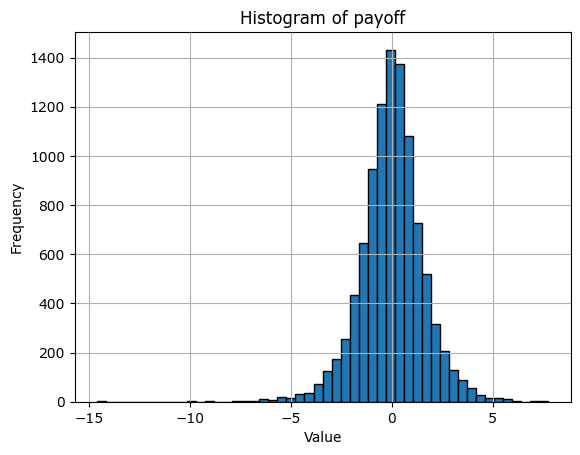

In [21]:
plt.hist(data, bins=50, edgecolor='black')
plt.title('Histogram of payoff')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualizing stock path


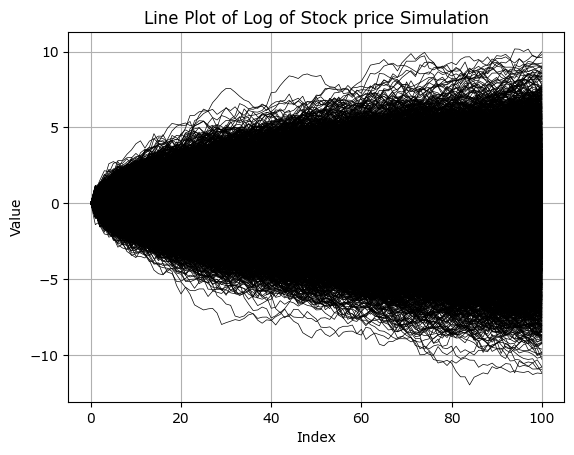

In [22]:
LogS=(np.log(S/stock)-(mu-interest)*np.tile(np.linspace(0, maturity, m+1), (n, 1)))/np.sqrt(maturity/m)
for i in range(LogS.shape[0]):
    plt.plot(LogS[i,:].reshape(-1), label='Column 1', linestyle='-', color='black', linewidth=0.5)
plt.title('Line Plot of Log of Stock price Simulation')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Analysing the profit/loss distribution

Using the code you have written (adapting it if necessary), please answer the following questions:

<OL>
    <LI>What happens to the profit/loss (P/L) distribution of the hedged position when you increase or decrease the number of time steps? Why do you think this is so?</LI>
    <LI>What happens to P/L distribution if you change $\mu$ in the objective measure dynamics? Why do you think this is so?</LI>
    <LI>What happens to P/L distribution if you hedge based on a lower volatility than you use to generate the Monte Carlo paths? If you hedge using a higher volatility? Why do you think this is so?</LI>
</OL>
Please add code and "Markdown" cells for your code and text answers below - <font color='red'>**remember not to overwrite your answers to previous questions above!**</font>


## Intial comments


The payoff when heging the call is as same as hedging the put with the same characteristics (strike, maturity, underlying asset, position). Then the following phenomenons when changing the parameter are the same for both call and put options.

$$
\pi_{call}(t)=S(t)(\Phi(d_1(s))-\Phi(d_1(t)))-Ke^{r(T-t)}(\Phi(d_2(s))-\Phi(d_2(t)))
\\
\pi_{put}(t)=Ke^{r(T-t)}(\Phi(-d_2(s))-\Phi(-d_2(t)))-S(t)(\Phi(-d_1(s))-\Phi(-d_1(t)))
\\
=Ke^{r(T-t)}(\Phi(d_2(t))-\Phi(d_2(s)))-S(t)(\Phi(d_1(t))-\Phi(d_1(s)))
\\
=S(t)(\Phi(d_1(s))-\Phi(d_1(t)))-Ke^{r(T-t)}(\Phi(d_2(s))-\Phi(d_2(t)))
\\
=\pi_{call}(t)
$$


## Question 1


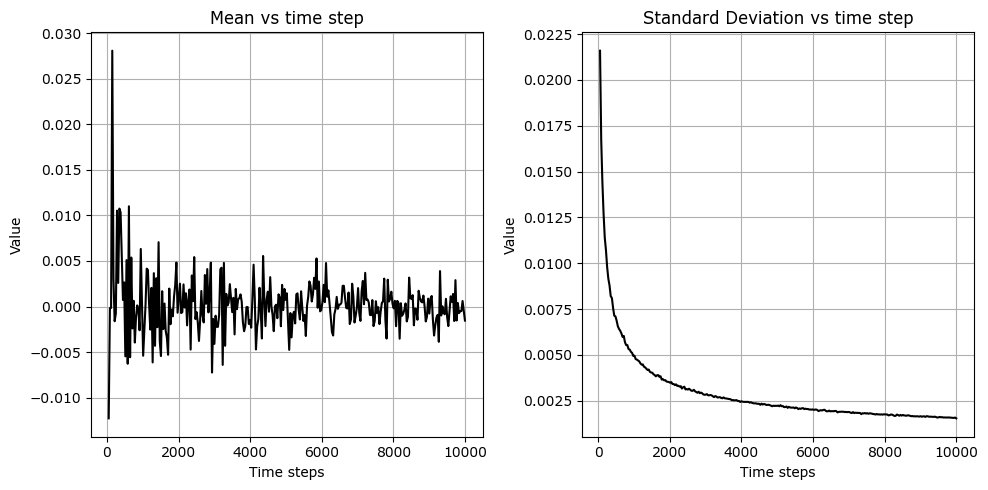

In [23]:
def Question_1():
    Mean, Std = [],[]
    steps = np.linspace(50,10000,301)
    np.random.seed(0)
    for x in steps:
        MC, MCstd, _, _ = BlackScholesHedgeMC(stock,strike,sigma,interest,maturity,callput,mu,n,int(x))
        Mean.append([x, MC])
        Std.append([x, MCstd])
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(list(map(lambda x: x[0], Mean)), list(map(lambda x: x[1], Mean)), linestyle='-', color='black')
    axs[0].set_title('Mean vs time step')
    axs[0].set_xlabel('Time steps')
    axs[0].set_ylabel('Value')
    axs[0].grid(True)
    axs[1].plot(list(map(lambda x: x[0], Std)), list(map(lambda x: x[1], Std)), linestyle='-', color='black')
    axs[1].set_title('Standard Deviation vs time step')
    axs[1].set_xlabel('Time steps')
    axs[1].set_ylabel('Value')
    axs[1].grid(True)
    plt.tight_layout()
    plt.show()
Question_1()

- When increasing the number of time step, the standard deviation of the P/L tend to reduce and the mean tends to reach closer to 0 with less fluctuation.
- When decreasing the number of time step, the standard deviation of the P/L tend to increase and the mean tends fluctuate more widely around 0.

This can be explained as when increasing in the number of time steps, we can increase in the frequency of hedging. Since then, the payoff will tends to be less fluctuated as we can reach to continously hedging if we keeps on increasing the time steps, which helps us to secure better the final payoff at the maturity. Furthermore, as we are reaching to the continously hedging when increase in the number of time step and the term structure is fixed, the mean of the P/L tends to reach to 0 with less fluctuation.


## Question 2


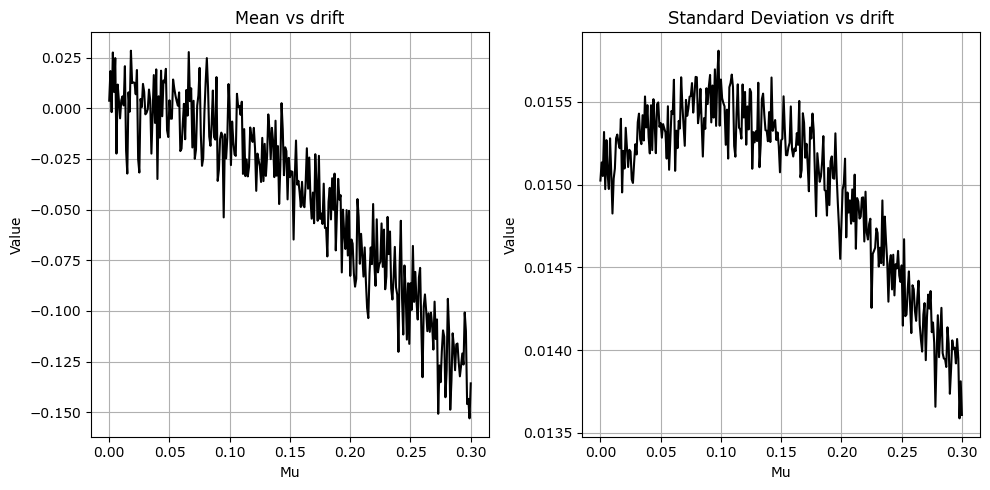

In [24]:
def Question_2():
    Mean, Std = [],[]
    mus = np.linspace(0,0.3,301)
    np.random.seed(0)
    for x in mus:
        MC, MCstd, _, _ = BlackScholesHedgeMC(stock,strike,sigma,interest,maturity,1,x,n,m)
        Mean.append([x, MC])
        Std.append([x, MCstd])
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(list(map(lambda x: x[0], Mean)), list(map(lambda x: x[1], Mean)), linestyle='-', color='black')
    axs[0].set_title('Mean vs drift')
    axs[0].set_xlabel('Mu')
    axs[0].set_ylabel('Value')
    axs[0].grid(True)
    axs[1].plot(list(map(lambda x: x[0], Std)), list(map(lambda x: x[1], Std)), linestyle='-', color='black')
    axs[1].set_title('Standard Deviation vs drift')
    axs[1].set_xlabel('Mu')
    axs[1].set_ylabel('Value')
    axs[1].grid(True)
    plt.tight_layout()
    plt.show()
Question_2()

- When increasing the $\mu$, the mean tends to decrease and the standard deviation tends to increase a bit and then decrease
- When decreasing the $\mu$, the mean tends to increase and the standard deviation tends to increase a while and then decrease

Reason for the mean: When increasing the $\mu$, the stock tends to increase in value. Then, the P/L from buying the hedging portfolio tend to decrease as we have to buy the new hedge portfolio with higher value of the replicating portfolio due to the reason that increasing in the stock value tends to increase in value of the portfolio with respected to the long position. Furthermore, when we hedge, we don't include with the drift of the stock as we are assuming that we are in arbitrage-free market where assets must grow mostly with the risk free rate so as not to occure the arbitrage.

Reason for the standard deviation: Initially, as we increase the drift, the expected stock price tends to move further from the strike price of the option (for calls, this means a higher likelihood of expiring in-the-money). This increases the potential range of outcomes, contributing to greater uncertainty in the portfolio's value, which leads to a higher standard deviation of payoffs. As the drift continues to increase, the stock price path becomes more deterministic, especially relative to the noise introduced by volatility. With a higher drift, the stock price grows exponentially, reducing the relative impact of randomness over time. This makes the future stock price less uncertain (less variance) because the dominant term becomes the drift, which is deterministic. At this point, dynamic hedging becomes more effective, reducing the standard deviation of the final payoff as the system becomes less influenced by volatility. Furthermore, for the when increase the drift, we tend to hold more position of the stock. Since then, we tend less need to hedge everyday (less rebalancing everyday). This would lead to a more certainty in the payoff at the maturity, which decrease the standard deviation of the payoff.

## Question 3


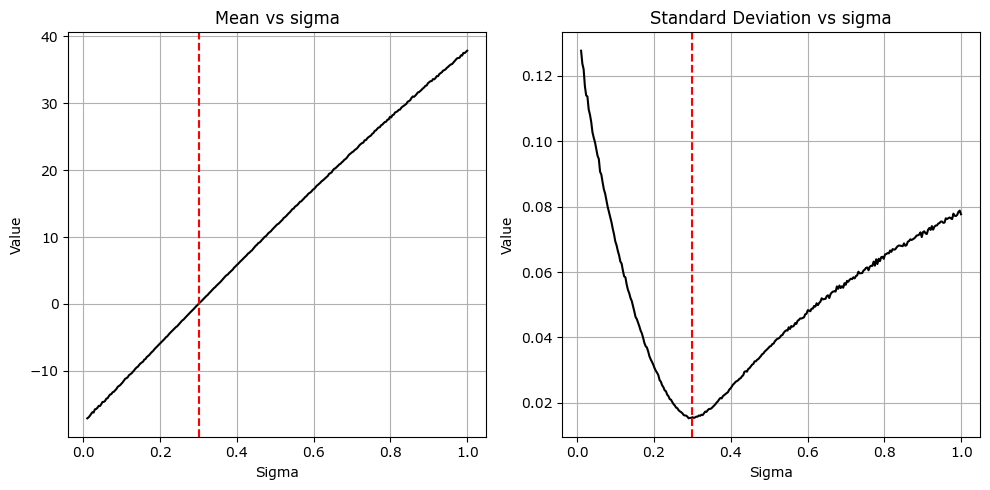

In [9]:
def Question_3():
    def BlackScholesHedgeMC(S,K,sgm,sgm2,r,T,callput,mu,n,m):
        delta_t = T/m
        z = np.random.standard_normal((n, m))
        Ss = S*np.exp(np.cumsum((mu-0.5*sgm**2)*delta_t+sgm*np.sqrt(delta_t)*z, axis=1))
        Ss = np.concat([np.repeat(S,n).reshape((n,1)),Ss], axis=1)
        payoff = np.apply_along_axis(lambda x: BlackScholesHedgePath(x,K,sgm2,r,T,callput), axis=1, arr=Ss)
        MC = np.mean(payoff)
        MCstd = np.std(payoff)/np.sqrt(n)
        return MC, MCstd
    MeanPositive, StdPositive= [],[]
    sigmas = np.linspace(0.01,1,301)
    np.random.seed(0)
    for x in sigmas:
        MC, MCstd = BlackScholesHedgeMC(stock,strike,sigma,x,0.02,maturity,1,0.07,n,m)
        MeanPositive.append([x, MC])
        StdPositive.append([x, MCstd])
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(list(map(lambda x: x[0], MeanPositive)), list(map(lambda x: x[1], MeanPositive)), linestyle='-', color='black')
    axs[0].axvline(x=sigma, color='r', linestyle='--')
    axs[0].set_title('Mean vs sigma')
    axs[0].set_xlabel('Sigma')
    axs[0].set_ylabel('Value')
    axs[0].grid(True)
    axs[1].plot(list(map(lambda x: x[0], StdPositive)), list(map(lambda x: x[1], StdPositive)), linestyle='-', color='black')
    axs[1].axvline(x=sigma, color='r', linestyle='--')
    axs[1].set_title('Standard Deviation vs sigma')
    axs[1].set_xlabel('Sigma')
    axs[1].set_ylabel('Value')
    axs[1].grid(True)
    plt.tight_layout()
    plt.show()
Question_3()

- When decreasing the $\sigma$ when hedging compared to the sigma applied for the stock simulation path, the mean tends to decrease and the standard deviation tends to increase.
- When increasing the $\sigma$ when hedging compared to the sigma applied for the stock simulation path, the mean tends to increase and the standard deviation tends to increase.

Reason for the mean: when we increasing in the sigma, we tends to hold more assets in our hedge portfolio. And in this case, due to the $\mu$ is greater than 0, our updated value of yesterday portfolio tends to be higher compared with the replicated portfolio of today. Then, the more increasing in the sigma, we tends to gain more (pay less) to have the new hedge portfolio. Hence, the mean of the payoff tends to increase when we increase the sigma.

Reason for the std: the purpose of the hedging is to eliminate the volatility term (the diffusion term) of the stock price. When we hedge less/more than it is required to eliminate the volatility term, there will be the remaining/excess term as we hold less/more assets that is require. By then, the std tends to be all higher compared when we hedge with the same sigma of the stock.
